# Training and Validation Script

## Import Library

In [1]:
import os
import re
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import gdown
import zipfile

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Import Dataset (Need to be automated and consistent)

In [2]:
url = "https://drive.google.com/file/d/1tYM-45FgvabZgCORbWcsmAHDQ4s10Eoi/view?usp=drive_link"
output = "dataset.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1tYM-45FgvabZgCORbWcsmAHDQ4s10Eoi
To: /content/dataset.zip
100%|██████████| 9.15M/9.15M [00:00<00:00, 114MB/s]


'dataset.zip'

In [3]:
# download zip file dataset from https://drive.google.com/drive/folders/1nwR-wo-_9mQtqkVJd3Grhlw6YGPX4EKP?usp=share_link
filenames = os.listdir()

for file in filenames:
  dataset = re.search(r'^dataset.*\.zip$', file)

  if dataset:
    zip_path = f'./{file}'
    zip_ref = zipfile.ZipFile(zip_path, 'r')
    zip_ref.extractall(path='./')
    zip_ref.close()

## ETL (Extract Transform Load)

In [4]:
# Extract (Specifying path)
base_dir = './dataset/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
# Extract (Generating dataset from directory)
BATCH_SIZE = 32
IMAGE_SIZE = (255, 255)
VAL_SPLIT = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    # labels='inferred',
    # label_mode='binary',
    # class_names=None,
    # batch_size=BATCH_SIZE,
    # image_size=IMAGE_SIZE,
    validation_split=VAL_SPLIT,
    subset='training',
    # shuffle=True,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    # labels='inferred',
    # label_mode='binary',
    # class_names=None,
    # batch_size=BATCH_SIZE,
    # image_size=IMAGE_SIZE,
    validation_split=VAL_SPLIT,
    subset='validation',
    # shuffle=True,
    seed=123
)

# test with very small dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    # labels='inferred',
    # label_mode='binary',
    # class_names=['caries', 'no-caries'],
    # batch_size=BATCH_SIZE,
    # image_size=IMAGE_SIZE,
    # shuffle=True,
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.
Found 32 files belonging to 2 classes.


In [6]:
# Check batches' shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Preprocessing Images using keras preprocessing layers

In [7]:
# Transform (Preprocessing data)

# optimize data I/O
AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = 255

image = next(iter(train_ds))

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal",
                    input_shape=(IMG_SIZE,
                                 IMG_SIZE,
                                 3)),
  layers.RandomRotation(0.1),
])

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Load (Apply preprocessing and load data)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [9]:
# # experimental ImageDatagenerator for training (not used at the moment)
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         # rotation_range=40,
#         # width_shift_range=0.2,
#         # height_shift_range=0.2,
#         # shear_range=0.2,
#         # zoom_range=0.2,
#         # horizontal_flip=True,
#         # fill_mode='nearest'
# )
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         train_dir,
#         target_size=(150, 150),
#         batch_size=20,
#         class_mode='binary')

# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=(150, 150),
#         batch_size=20,
#         class_mode='binary')

### Building Model using Transfer Learning

In [10]:
# transfer learning not final (maybe can use less layer?)
# model_selection = ("mobilenet_v2", 224, 1280) 
# handle_base, pixels, FV_SIZE = model_selection
# IMAGE_SIZE = (pixels, pixels)

# MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
# feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,))
# feature_extractor.trainable = False



In [11]:
# Inception V3 model
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), 
                                include_top = False, 
                                weights = 'imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [12]:
# prepare layers for transfer learning
for layer in pre_trained_model.layers:
    layer.trainable = False

In [13]:
# # not final
# model = tf.keras.Sequential([
#   feature_extractor,
#   tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid/softmax
# ])

# model.summary()

In [14]:
# Model building
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [15]:
model.compile(
  optimizer = optimizers.Adam(learning_rate=0.0001), 
  loss = 'binary_crossentropy', 
  metrics = ['accuracy']
)

## Model Training

In [16]:
# Input runs out of data problem
history = model.fit(
  train_ds,
  validation_data = val_ds,
  # steps_per_epoch = 4,
  epochs = 20,
  # validation_steps = 4,
  verbose = 2)

Epoch 1/20
13/13 - 117s - loss: 2.8831 - accuracy: 0.7050 - val_loss: 0.9326 - val_accuracy: 0.8700 - 117s/epoch - 9s/step
Epoch 2/20
13/13 - 105s - loss: 0.4469 - accuracy: 0.8825 - val_loss: 0.0729 - val_accuracy: 0.9600 - 105s/epoch - 8s/step
Epoch 3/20
13/13 - 103s - loss: 0.1279 - accuracy: 0.9550 - val_loss: 0.0418 - val_accuracy: 0.9800 - 103s/epoch - 8s/step
Epoch 4/20
13/13 - 105s - loss: 0.0603 - accuracy: 0.9800 - val_loss: 0.0224 - val_accuracy: 0.9900 - 105s/epoch - 8s/step
Epoch 5/20
13/13 - 107s - loss: 0.0366 - accuracy: 0.9875 - val_loss: 0.0315 - val_accuracy: 0.9800 - 107s/epoch - 8s/step
Epoch 6/20
13/13 - 104s - loss: 0.0493 - accuracy: 0.9825 - val_loss: 0.0219 - val_accuracy: 0.9900 - 104s/epoch - 8s/step
Epoch 7/20
13/13 - 107s - loss: 0.0345 - accuracy: 0.9850 - val_loss: 0.0282 - val_accuracy: 0.9800 - 107s/epoch - 8s/step
Epoch 8/20
13/13 - 106s - loss: 0.0150 - accuracy: 0.9950 - val_loss: 0.0169 - val_accuracy: 1.0000 - 106s/epoch - 8s/step
Epoch 9/20
13/13

## Model Evaluation

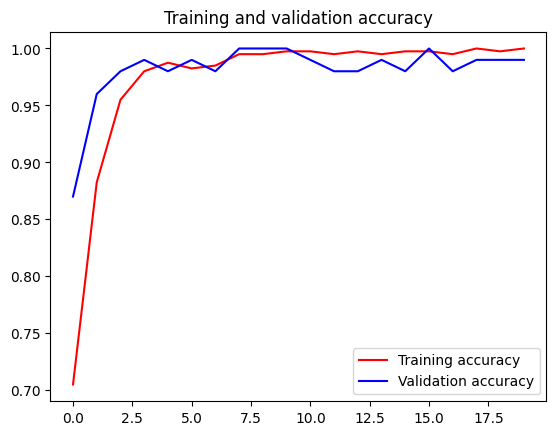

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [19]:
# change filename to file you want to predict
filename = 'caries.jpg'
img = load_img(filename, target_size=(255, 255))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)

1/1 [==============================] - 1s 577ms/step
[[0.9999362]]


## TODO
* Build Flask app
* User image input???????
* Create better evaluation and prediction
* Create save model function to .h5 format
* How to deploy the model?